# Cartographie des pays associés aux publications de Paris 8

Le notebook permet de cartographier les pays des auteurs qui ont signé une ou plusieurs publications avec des chercheur.es de Paris 8. Par Pays, on entend le pays des établissements auxquels ces auteurs sont associés.

Les données géographiques sont issues du Baromètre Science Ouverte de Paris 8 réalisé en 2025. Dans de nombreux cas, les données sont manquantes, c'est-à-dire qu'il n'y a pas le nom du pays.

On procède en 2 temps :

1. On extrait le pays associés aux auteurs de chaque pays, puis on compte le nombre de publication par pays

2. On utilise geopandas pour construire les données géographiques à partir des noms de pays et dessiner la carte.



In [1]:

import pandas as pd
import os
import s3fs

import datetime
import json
import re
import tqdm

In [2]:
#Library for social network analysis
import numpy as np
#import plotly.express as px


# Chargement des fichiers de données et préparation du dataframe

On charge le fichier créé à partur du notebook "network_hal_p8-Copy1.ipynb".

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET_OUT = "aluneau"
FILE_KEY_S3 = "Data_bso/outputs/publis/2026-02-18_list_of_publi_from_bso.csv"
FILE_PATH_S3 = BUCKET_OUT + "/" + FILE_KEY_S3



In [7]:
with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    df0 = pd.read_csv(file_in, sep=",")

df0.drop(columns=["Unnamed: 0"], inplace=True)

Le `df0` comporte une ligne par publication. On utilise les fonctions `split` et `explode` de pandas pour créer un nouveau dataframe avec une ligne par publication et pays.

In [12]:
df0["name_country"] = df0.struc_country.str.split("|")
df_country = df0[["id", "name_country"]].explode("name_country").drop_duplicates()
df_country.name_country.nunique()

107

## Regroupement par pays

Pour chaque pays, on compte le nombre de publications associés via la fonction "groupby" de pandas. 

In [17]:
freq_country = df_country.groupby(["name_country"]).agg(nb=("id","size")).sort_values("nb", ascending= False).reset_index()
freq_country["freq"] = freq_country.nb/ np.sum(freq_country.nb)
freq_country.head(10)

,name_country,nb,freq
0,no country,37698,0.695381
1,France,13306,0.245444
2,Italy,286,0.005276
3,United States,261,0.004814
4,Switzerland,236,0.004353
5,Belgium,209,0.003855
6,United Kingdom,202,0.003726
7,Canada,192,0.003542
8,Germany,191,0.003523
9,Spain,167,0.003080


On constate ainsi que près de 70% des publications ont au moins un auteur sans "pays".  Par ailleurs la France est clairement surreprésentée et "écrase" les autres pays.

Il peut donc être intéressant de retirer ces deux modalités du décomptes et, *in fine*, de la représentation cartographique.


In [20]:
freq_country = df_country.loc[~df_country.name_country.isin(["France", "no country"])].groupby(["name_country"]).agg(nb=("id","size")).sort_values("nb", ascending= False).reset_index()
freq_country["freq"] = freq_country.nb/ np.sum(freq_country.nb)*100
freq_country.head(10)

,name_country,nb,freq
0,Italy,286,8.915212
1,United States,261,8.135910
2,Switzerland,236,7.356608
3,Belgium,209,6.514963
4,United Kingdom,202,6.296758
5,Canada,192,5.985037
6,Germany,191,5.953865
7,Spain,167,5.205736
8,Tunisia,114,3.553616
9,Greece,90,2.805486


In [21]:
!pip3 install contextily

In [35]:
import geopandas as gp
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import contextily as ctx
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly

## Retrouver les coordonnées géospaciale des pays

Nous utilisons les modules geopandas et geopy qui permettent de manipuler facilement les données géospaciales. Geopandas est d'une certaine manière une extension de pandas.
Geopy propose des fonctions pour retrouver les coordonnées d'entité géographique (villes, régions, pays, etc.

**EPSG** est l'acronyme d'European Petroleum Survey Group. Code associé à l'un des paramètres géodésiques établis par l'EPSG et gérés par le Comité sur la géomatique de l'IOGP 

In [25]:

dfg = gp.GeoDataFrame(freq_country.loc[freq_country.name_country != 'no country'])


# Source - https://stackoverflow.com/a/61346493
# Posted by hyances, modified by community. See post 'Timeline' for change history
# Retrieved 2026-02-18, License - CC BY-SA 4.0

dfg['geometry'] = gp.tools.geocode(dfg.name_country).geometry 
dfg.crs = "EPSG:4326" 
dfg.head()



/tmp/ipykernel_7526/3883915770.py:8: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  dfg['geometry'] = gp.tools.geocode(dfg.name_country).geometry


,name_country,nb,freq,geometry
0,Italy,286,8.915212,POINT (12.6743 42.63843)
1,United States,261,8.135910,POINT (-100.44588 39.78373)
2,Switzerland,236,7.356608,POINT (8.23197 46.79856)
3,Belgium,209,6.514963,POINT (4.66671 50.64028)
4,United Kingdom,202,6.296758,POINT (-3.27658 54.70235)


On a une nouvelle colonne ("geometry") qui correspond à la longitude et la latitude : `POINT (LONG LAT)`. On enregistre le dataframe pour pouvoir le réutiliser plus tard


In [26]:
FILE_PATH_OUT_S3 = BUCKET_OUT + "/" + "outputs/publis/2026-02-19_country_name_with_location_point"
with fs.open(f"{FILE_PATH_OUT_S3}.csv", 'w') as file_out:
    dfg.to_csv(file_out, sep = ",", index = False)
    


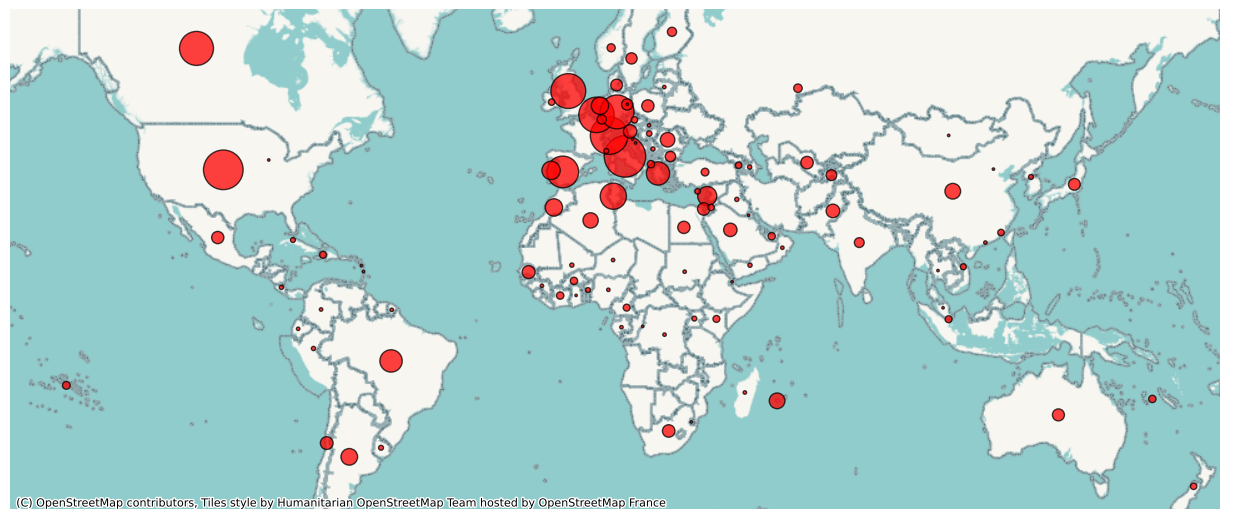

In [34]:
dfg1 = dfg.to_crs(epsg=3857)
ax = dfg1.plot(figsize=(16, 10), alpha=0.75, edgecolor='k', marker='o', color='red', markersize=dfg1.freq*100)
ctx.add_basemap(ax)
ax.set_axis_off()

Comme on le voit sur la carte, la fréquence des publications est représentée par un point. Cela est lié au fait que dans la colonne "geometry" on utilise la longitude et la latitude. Dans les cellules ci-dessous, nous allons récupérer cette fois les coordonnées correspondant aux "frontières" des pays. De cette manière, nous pourrons colorier la surface des pays en fonction de la fréquence des coopérations (mesurée en nombre de publication), c'est-à-dire obtenir ce qu'on appelle une corothplèthe.

* un exemple de corothplèthe:

![https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Carte_figurative_de_l%27instruction_populaire_de_la_France.jpg/330px-Carte_figurative_de_l%27instruction_populaire_de_la_France.jpg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Carte_figurative_de_l%27instruction_populaire_de_la_France.jpg/330px-Carte_figurative_de_l%27instruction_populaire_de_la_France.jpg)



Pour cela, il nous faut d'abord récupérer les coordonées des frontières de chaque pays à partir des données disponibles sur le web. Nous proposons ici d'utiliser les jeux de données disponible sur l'entrepôt recherche.data.gouv de la [*Toulouse School of Economics*](https://entrepot.recherche.data.gouv.fr/dataset.xhtml?persistentId=doi:10.57745/ABJ8OQ) :  

> James, Kyllian, 2025, "World Countries Boundaries", [https://doi.org/10.57745/ABJ8OQ](https://doi.org/10.57745/ABJ8OQ), Recherche Data Gouv, V1

Il contient des pays tels que Taiwan qui ne sont pas dans les [fichiers proposés par la Banque Mondiale](https://datacatalog.worldbank.org/search/dataset/0038272/world-bank-official-boundaries).

In [36]:
fp = "World_Countries_Boundaries.geojson"
map_df = gp.read_file(fp)

In [37]:
map_df.crs = "EPSG:4326"


On peut facilement visualiser les données obtenues avec la fonction `gp_dataframe.plot()`

<Axes: >

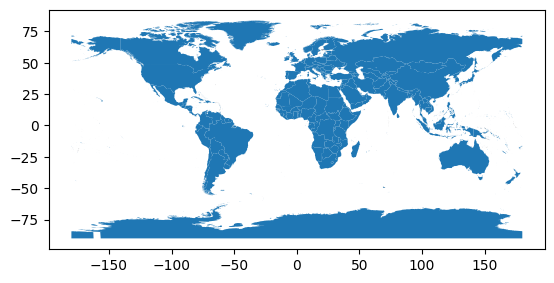

In [38]:
map_df.plot()

## "Fusion" des dataframe dfg et map_df

Une fois les données des frontières obtenues, nous pouvons fusionnés le dataframe avec celui que nous avons créés précédemment à partir des pays "co-publiant" avec les chercheur.es de Paris 8. Toutefois, ke nom des pays peut varier. Nous allons alors nous appuyés sur la longitude et la latitude. Nous récupérons les coordonnées à l'aide `gp.tools.geocode`.

In [39]:
#GET POint of country

map_df['geometry'] = gp.tools.geocode(map_df.COUNTRY).geometry 
map_df.crs = "EPSG:4326"
map_df.head(5)
    

,NAME,VISUALIZATION_NAME,ISO2,ISO3,M49_CODE,SOVRN,Claimed,COUNTRY,CONTINENT,CONTINENT_CODE,...,AREA,BBOX_AREA,Centroid_X,Centroid_Y,Centroid_of_LARGEST_POLYGON_X,Centroid_of_LARGEST_POLYGON_Y,BBOX_Centroid_X,BBOX_Centroid_Y,SOURCE,geometry
0,UNITED ARAB EMIRATES,United Arab Emirates,AE,ARE,784,United Arab Emirates,None,United Arab Emirates,ASIA,142,...,70698.18810,186543.02326,54.325459,23.914248,54.330892,23.910651,53.982513,24.369802,World Health OrGanization (WHO) - Countries,POINT (53.99948 24.00025)
1,BURUNDI,Burundi,BI,BDI,108,Burundi,None,Burundi,AFRICA,002,...,27302.60165,49628.04671,29.886949,-3.356094,29.886949,-3.356094,29.918884,-3.373007,World Health OrGanization (WHO) - Countries,POINT (29.93245 -3.42645)
2,BENIN,Benin,BJ,BEN,204,Benin,None,Benin,AFRICA,002,...,116651.76952,231996.26646,2.342094,9.641538,2.342094,9.641538,2.315887,9.301888,World Health OrGanization (WHO) - Countries,POINT (2.25844 9.52935)
3,BURKINA FASO,Burkina Faso,BF,BFA,854,Burkina Faso,None,Burkina Faso,AFRICA,002,...,273386.92902,544892.00016,-1.746339,12.279180,-1.746339,12.279180,-1.561615,12.256439,World Health OrGanization (WHO) - Countries,POINT (-1.68803 12.07531)
4,BANGLADESH,Bangladesh,BD,BGD,050,Bangladesh,None,Bangladesh,ASIA,142,...,139119.42242,308677.02121,90.280284,23.826046,90.262585,23.869698,90.356293,23.680009,World Health OrGanization (WHO) - Countries,POINT (90.29344 24.47693)


On ne garde que les colonnes utiles et nous fusionnons les deux dataframe en utilisant la colonne geometry pour faire la jointure.


In [52]:
#Merge dfg with map_df
list_of_column = ['NAME', 'VISUALIZATION_NAME', 'ISO2','SOVRN','COUNTRY', 'CONTINENT','SOURCE', 'geometry']
dfg_harm = dfg.merge(map_df[list_of_column], on = ["geometry"], how = "left")
dfg_harm.loc[dfg_harm.COUNTRY.isna()]

,name_country,nb,freq,geometry,NAME,VISUALIZATION_NAME,ISO2,SOVRN,COUNTRY,CONTINENT,SOURCE
1,United States,261,8.135910,POINT (-100.44588 39.78373),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Kingdom,202,6.296758,POINT (-3.27658 54.70235),NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,"Iran, Islamic Republic of",21,0.654613,POINT (13.29996 52.46095),NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,Hong Kong,2,0.062344,POINT (114.1858 22.34922),NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,"Venezuela, Bolivarian Republic of",1,0.031172,POINT (-87.63731 41.88288),NaN,NaN,NaN,NaN,NaN,NaN,NaN


On constate malheureusement que dans certains cas, la jointure n'a pas fonctionné. Les coodonnées ne correspondent pas.

Comme les données manquantes ne sont pas nombreuses, nous allons les complétées manuellement en allant chercher les coordonées dans `map_df`.

In [53]:
unmatch = dfg_harm.loc[dfg_harm.COUNTRY.isna()]

# dictionnaire faisant correspond le name_country de dfg avec 'VISUALIZATION_NAME' dans map_df
dict_state = {'United States' : 'United States of America',
 'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
 'Iran, Islamic Republic of' : 'Iran',
 'Hong Kong' : 'Hong Kong SAR',
 'Venezuela, Bolivarian Republic of':'Venezuela'}

# On crée une nouvelle colonne 'VISUALIZATION_NAME' et on merge unmatch avec map_df en prenant 'VISUALIZATION_NAME' comme colonne de jointure
unmatch["VISUALIZATION_NAME"] = unmatch.name_country.map(dict_state.get)
unmatch = unmatch[["name_country","nb","freq","VISUALIZATION_NAME"]].merge(map_df[list_of_column], on = ['VISUALIZATION_NAME'], how = "left")

unmatch

/opt/python/lib/python3.13/site-packages/geopandas/geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,name_country,nb,freq,VISUALIZATION_NAME,NAME,ISO2,SOVRN,COUNTRY,CONTINENT,SOURCE,geometry
0,United States,261,8.135910,United States of America,UNITED STATES OF AMERICA,US,United States of America,United States of America,AMERICAS,World Health OrGanization (WHO) - Countries an...,POINT (-87.6375 41.88385)
1,United Kingdom,202,6.296758,United Kingdom of Great Britain and Northern I...,UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN I...,GB,United Kingdom of Great Britain and Northern I...,United Kingdom of Great Britain and Northern I...,EUROPE,World Health OrGanization (WHO) - Countries an...,POINT (13.38073 52.51562)
2,"Iran, Islamic Republic of",21,0.654613,Iran,IRAN,IR,Iran,Iran,ASIA,World Health OrGanization (WHO) - Countries an...,POINT (54.56435 32.64753)
3,Hong Kong,2,0.062344,Hong Kong SAR,HONG KONG SAR,HK,China,China,ASIA,Fondation Jean-Jacques Laffont - Toulouse Scie...,POINT (104.99993 35.00007)
4,"Venezuela, Bolivarian Republic of",1,0.031172,Venezuela,VENEZUELA,VE,Venezuela,Venezuela,AMERICAS,World Health OrGanization (WHO) - Countries an...,POINT (-66.11093 8.00187)


Nous n'avons plus de données manquantes. Nous pouvons reconstituer le jeu de données en concaténant les lignes qui ne posaient pas de problème avec les 5 lignes que nous venons de compléter.

In [54]:
match = dfg_harm.loc[~dfg_harm.COUNTRY.isna()]


In [55]:
dfg_harm = pd.concat([match,unmatch])
dfg_harm

,name_country,nb,freq,geometry,NAME,VISUALIZATION_NAME,ISO2,SOVRN,COUNTRY,CONTINENT,SOURCE
0,Italy,286,8.915212,POINT (12.6743 42.63843),ITALY,Italy,IT,Italy,Italy,EUROPE,World Health OrGanization (WHO) - Countries an...
2,Switzerland,236,7.356608,POINT (8.23197 46.79856),SWITZERLAND,Switzerland,CH,Switzerland,Switzerland,EUROPE,World Health OrGanization (WHO) - Countries
3,Belgium,209,6.514963,POINT (4.66671 50.64028),BELGIUM,Belgium,BE,Belgium,Belgium,EUROPE,World Health OrGanization (WHO) - Countries an...
5,Canada,192,5.985037,POINT (-107.99171 61.06669),CANADA,Canada,CA,Canada,Canada,AMERICAS,World Health OrGanization (WHO) - Countries an...
6,Germany,191,5.953865,POINT (10.44783 51.16382),GERMANY,Germany,DE,Germany,Germany,EUROPE,World Health OrGanization (WHO) - Countries an...
...,...,...,...,...,...,...,...,...,...,...,...
0,United States,261,8.135910,POINT (-87.6375 41.88385),UNITED STATES OF AMERICA,United States of America,US,United States of America,United States of America,AMERICAS,World Health OrGanization (WHO) - Countries an...
1,United Kingdom,202,6.296758,POINT (13.38073 52.51562),UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN I...,United Kingdom of Great Britain and Northern I...,GB,United Kingdom of Great Britain and Northern I...,United Kingdom of Great Britain and Northern I...,EUROPE,World Health OrGanization (WHO) - Countries an...
2,"Iran, Islamic Republic of",21,0.654613,POINT (54.56435 32.64753),IRAN,Iran,IR,Iran,Iran,ASIA,World Health OrGanization (WHO) - Countries an...
3,Hong Kong,2,0.062344,POINT (104.99993 35.00007),HONG KONG SAR,Hong Kong SAR,HK,China,China,ASIA,Fondation Jean-Jacques Laffont - Toulouse Scie...


Les noms de pays étant maintenant harmonisés, nous pouvons joindre les coordonnées des frontières au dataframe 'dfg_harm' et tracer enfin notre corothplèthe.

In [56]:
fp = "World_Countries_Boundaries.geojson"
map_poly = gp.read_file(fp)
map_poly.crs = "EPSG:4326"
dict_polygone = dict(zip(map_poly.VISUALIZATION_NAME, map_poly.geometry))

dfg_harm = dfg_harm.rename(columns={"geometry":"point"})
dfg_harm["geometry"] = dfg_harm.VISUALIZATION_NAME.map(dict_polygone.get)


In [90]:
FILE_PATH_OUT_S3 = BUCKET_OUT + "/" + "outputs/publis/2026-02-19_country_name_with_polygone"
with fs.open(f"{FILE_PATH_OUT_S3}.csv", 'w') as file_out:
    dfg_harm.to_csv(file_out, sep = ",", index = False)

## Vue mondiale

Text(0.5, 1.0, 'Pays des auteurs ayant signé une ou plusieurs publications avec des chercheur.es de Paris 8 (données issues du Barometre science ouverte)')

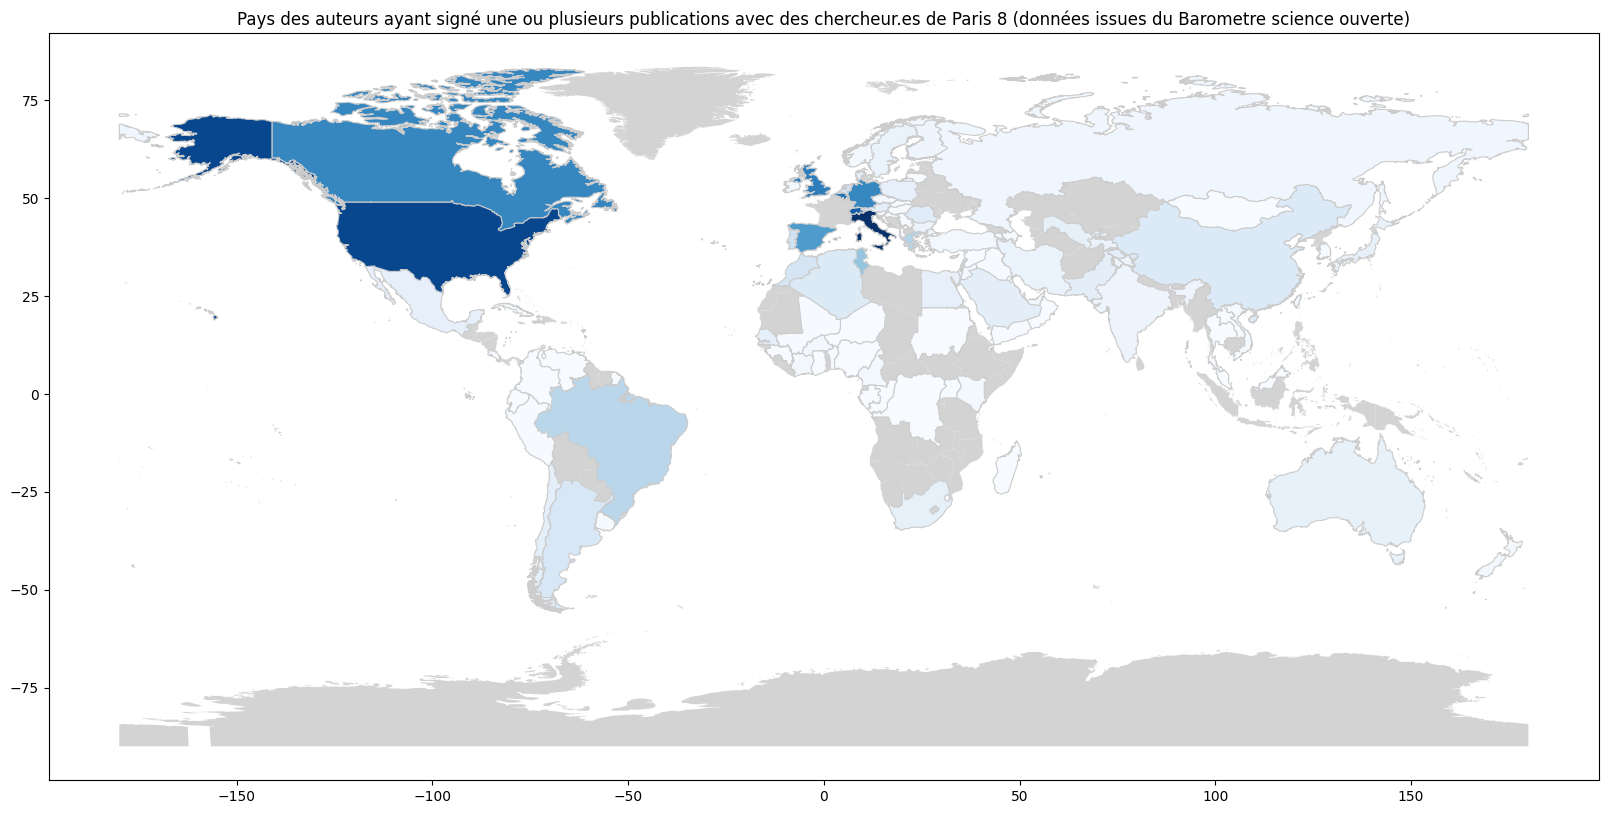

In [64]:
fig, ax = plt.subplots(figsize = (20,20))
map_poly.plot(ax=ax, color='lightgrey')
dfg_harm.plot(column="freq", cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title('Pays des auteurs ayant signé une ou plusieurs publications avec des chercheur.es de Paris 8 (données issues du Barometre science ouverte)')

## Zoom sur l'europe

In [75]:
dfg_europe = dfg_harm.loc[(dfg_harm.CONTINENT == "EUROPE") & (dfg_harm.VISUALIZATION_NAME!='Russian Federation')]
map_europe = map_poly.loc[(map_poly.CONTINENT == "EUROPE") & (map_poly.VISUALIZATION_NAME!='Russian Federation')]



Text(0.5, 1.0, 'Pays des auteurs ayant signé une ou plusieurs publications avec des chercheur.es de Paris 8 (données issues du Barometre science ouverte)')

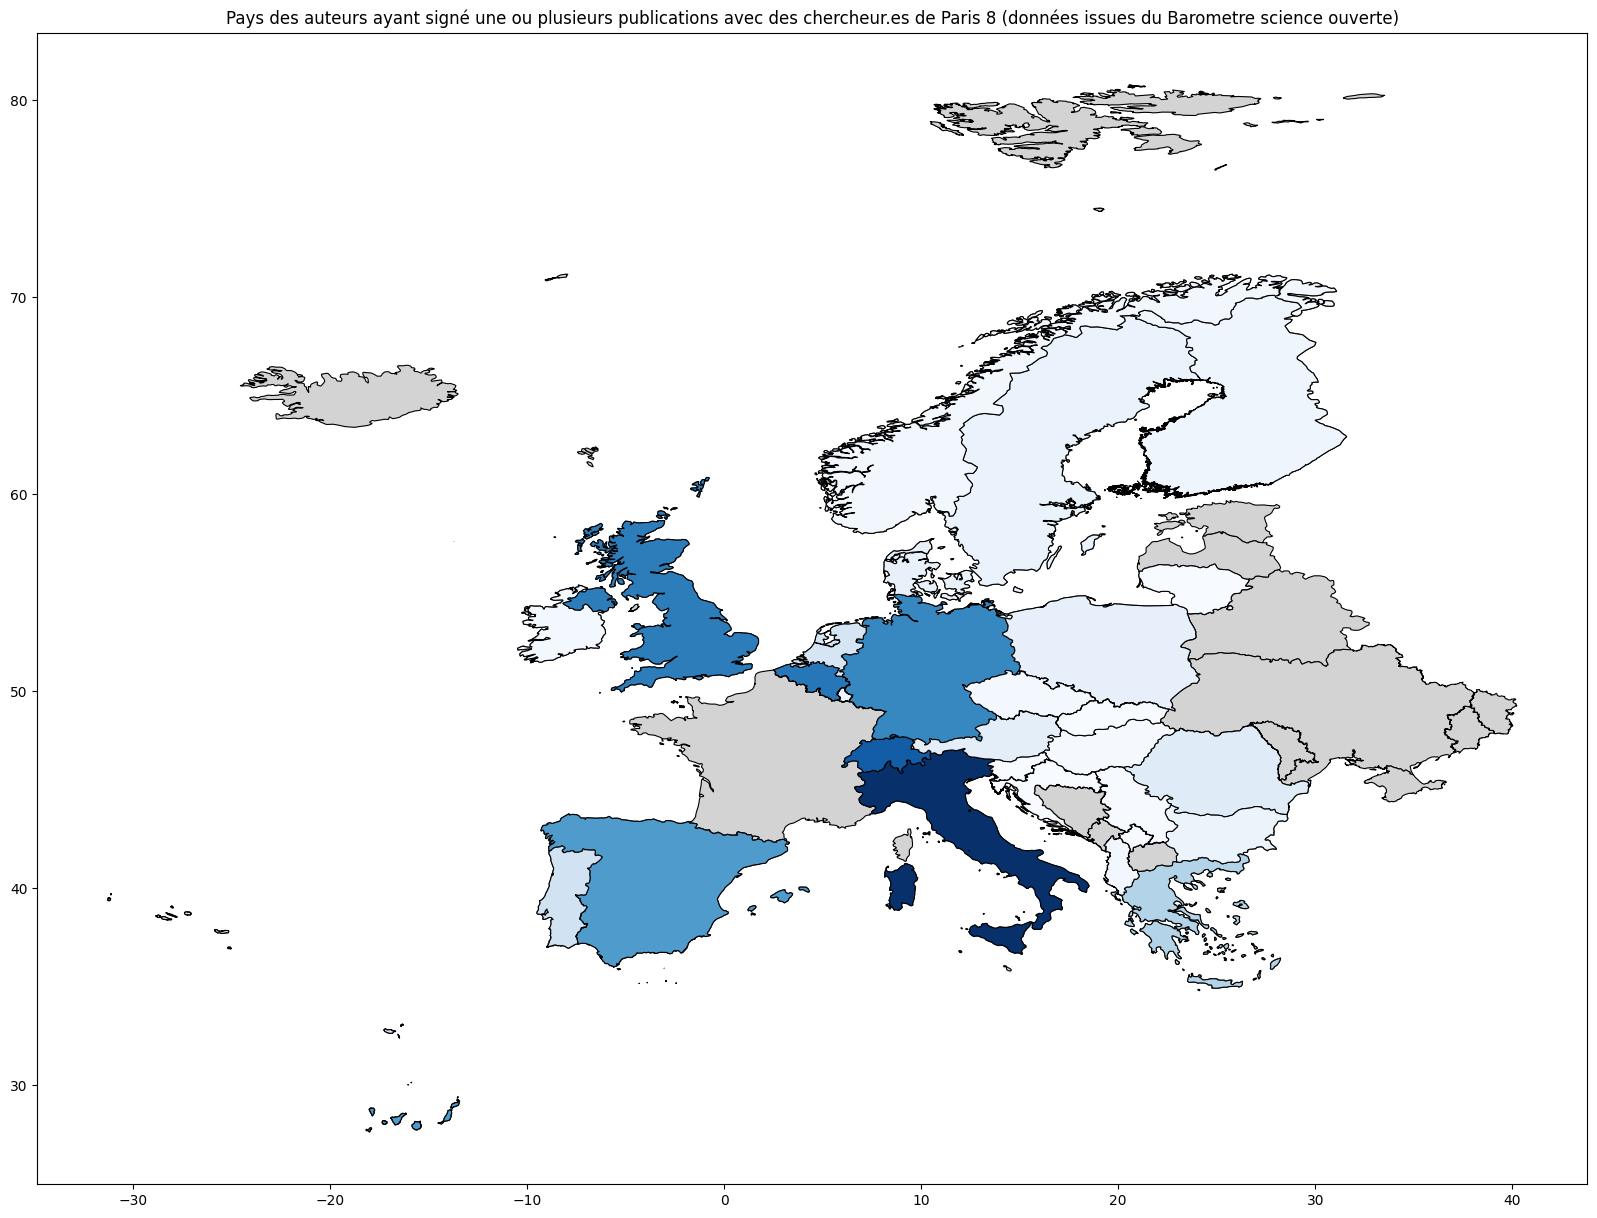

In [89]:
fig, ax = plt.subplots(figsize = (20,20))
map_europe.plot(ax=ax, color='lightgrey',linewidth=0.8, edgecolor='0')
dfg_europe.plot(column="freq", cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0')
ax.set_title('Pays des auteurs ayant signé une ou plusieurs publications avec des chercheur.es de Paris 8 (données issues du Barometre science ouverte)')

In [78]:
dfg_africa = dfg_harm.loc[(dfg_harm.CONTINENT == "AFRICA")]
map_africa = map_poly.loc[(map_poly.CONTINENT == "AFRICA")]



Text(0.5, 1.0, 'Pays des auteurs ayant signé une ou plusieurs publications avec des chercheur.es de Paris 8 (données issues du Barometre science ouverte)')

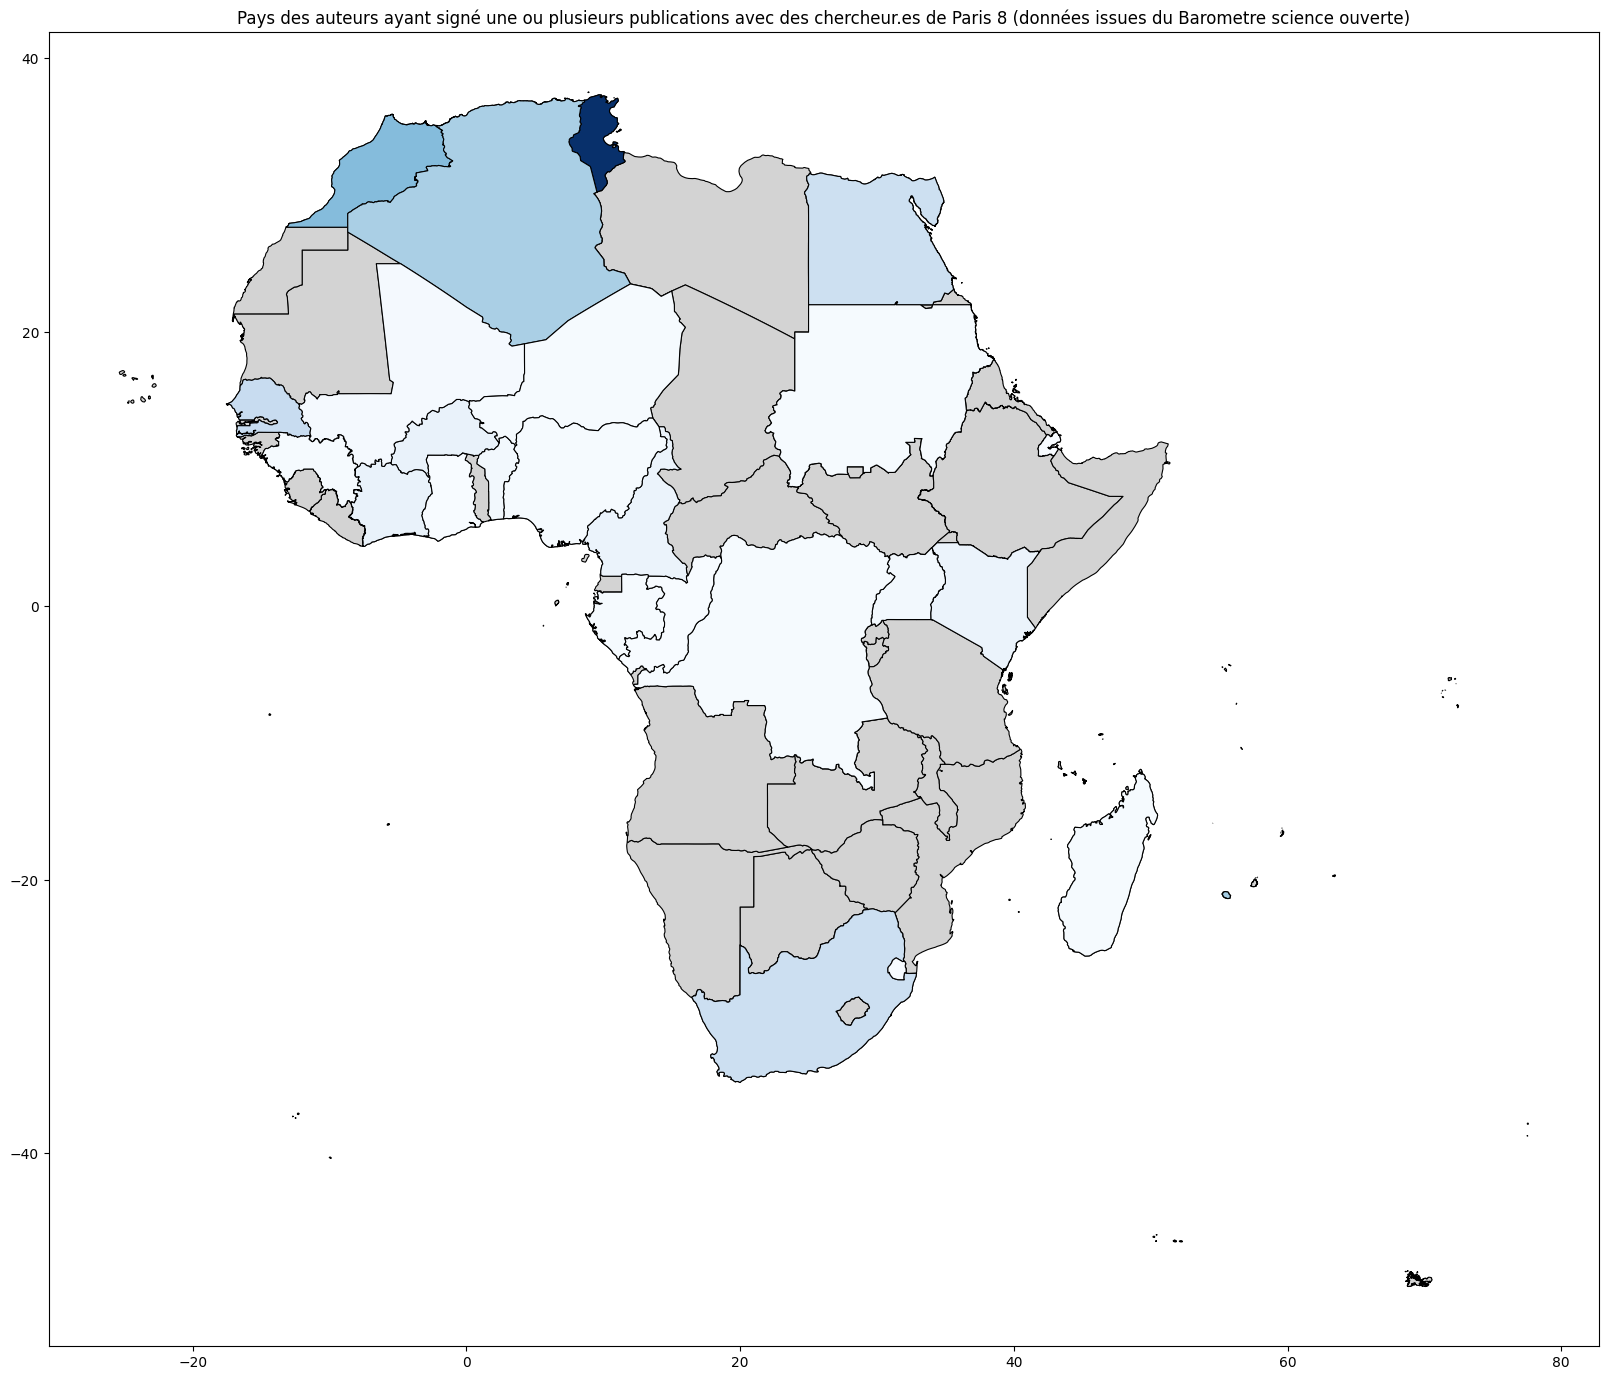

In [88]:
fig, ax = plt.subplots(figsize = (20,20))
map_africa.plot(ax=ax, color='lightgrey',linewidth=0.8, edgecolor='0')
dfg_africa.plot(column="freq", cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0')
ax.set_title('Pays des auteurs ayant signé une ou plusieurs publications avec des chercheur.es de Paris 8 (données issues du Barometre science ouverte)')

/tmp/ipykernel_7526/2762356138.py:10: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dfg_tmp.plot(column="freq", cmap='Blues', linewidth=0.8, ax=axs[n], edgecolor='0')


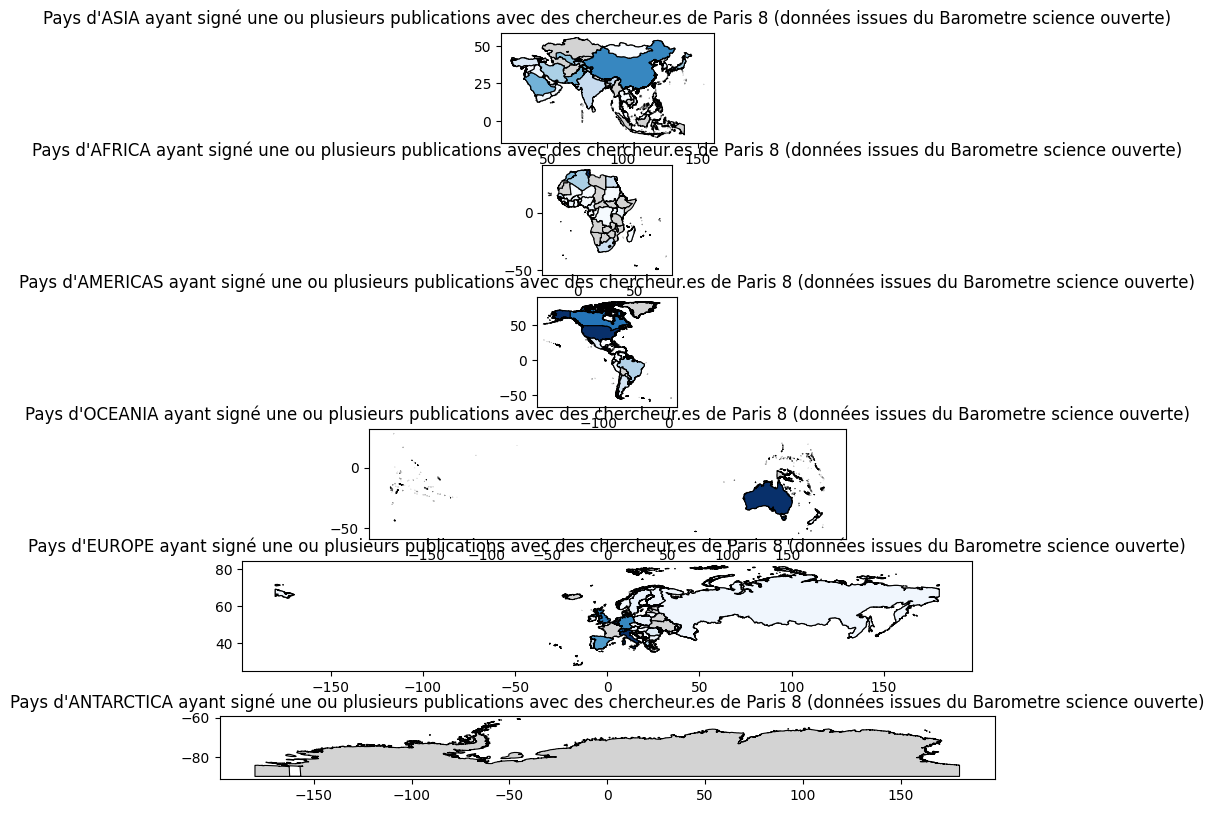

In [92]:
list_continent = [x for x in map_poly.CONTINENT.unique()]
fig, axs = plt.subplots(len(list_continent), figsize = (10,10))

for n, cont in enumerate(list_continent):
    dfg_tmp = dfg_harm.loc[(dfg_harm.CONTINENT == cont)]
    map_tmp = map_poly.loc[(map_poly.CONTINENT == cont)]


    map_tmp.plot(ax=axs[n], color='lightgrey',linewidth=0.8, edgecolor='0')
    dfg_tmp.plot(column="freq", cmap='Blues', linewidth=0.8, ax=axs[n], edgecolor='0')
    axs[n].set_title(f'Pays d\'{cont} ayant signé une ou plusieurs publications avec des chercheur.es de Paris 8 (données issues du Barometre science ouverte)')